<a href="https://colab.research.google.com/github/focussed/etivity1/blob/master/Etivity4_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEV: Comparison of Binary Classifiers

We will train a binary classification model to predict the diagnosis. We assume that misclassifying diagnosis M as B is more costly than misclassifying B as M, as cases classified as M can be further tested, while malignant cases misclassified as B may remain unnoticed. In other words, we would like to train a model that has high recall for class M, while the precision of the model for class M is not that important.

The `diagnosis` column is the *dependent variable* or *target* for classification, while all other columns are the *predictors*. We will use the common convention to refer to the predictors as **X** and to the target as **y**.  

In the process of training the dataset will be split into a training set and a test set. The training set will be further split (multiple times) into a training and validation set in a cross-validation procedure for tuning the parameters of two alternative classifiers: SVM and Random Forest.

Note that any data preparation of the predictors needs to be applied separately to each of these sets.

In [0]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from scipy import interp
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## EDA

In [39]:
url = 'https://raw.githubusercontent.com/focussed/etivity1/master/seeds.csv'
df = pd.read_csv(url)
print('(number of examples, number of attributes): ', df.shape)
df.head()

(number of examples, number of attributes):  (210, 8)


,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [40]:
df['type'].value_counts()

3    70
2    70
1    70
Name: type, dtype: int64

First of all let's check for missing values and outliers.

In [41]:
df.isnull().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

There are no missing values. Let's check the boxplots of the numerical columns for outliers. We will do this in three slices.

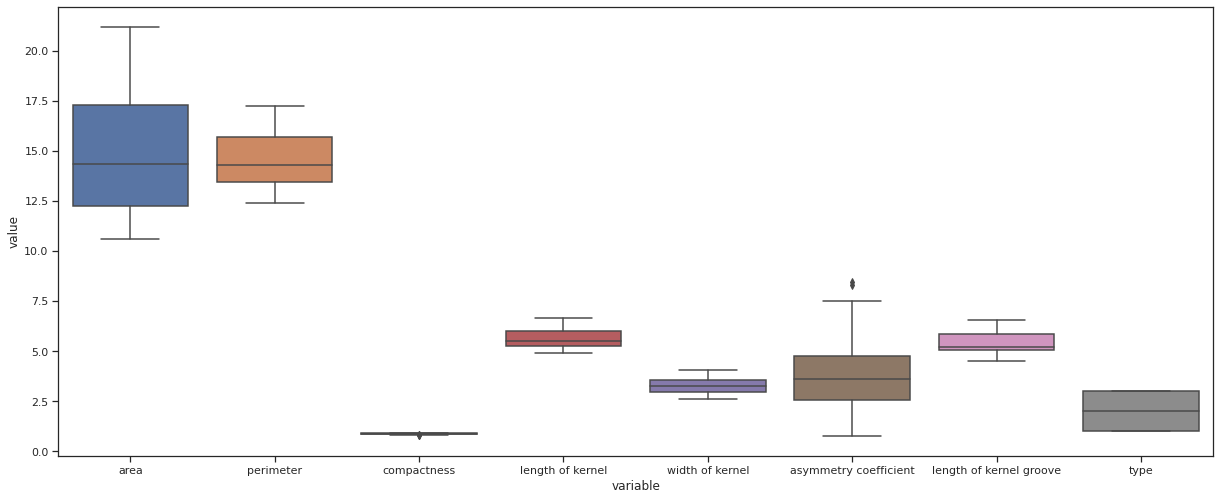

In [42]:
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(20.7, 8.27)
sns.boxplot(x="variable", y="value", data=pd.melt(df))
plt.show()

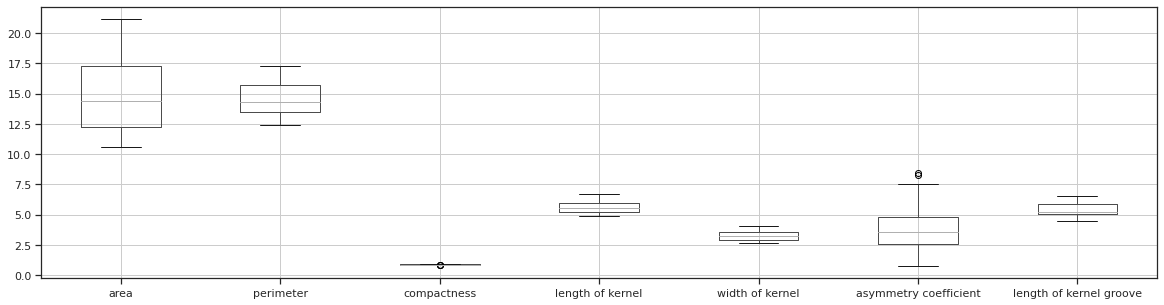

In [43]:
df.loc[:,'area':'length of kernel groove'].boxplot(figsize=(20,5))
plt.show()

All columns appear to have no outliers other than the 'asymmetry coefficient'.  Even at that, it is a valid flower dimension, so it should not be discounted.  

We will apply log transformation followed by `RobustScaler` to them. To all other predictor columns we will apply `StandardScaler`.  

In [44]:
df.describe()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,2.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,1.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,2.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,3.000000


## Data Preparation
All columns are in numerical format.  The type column is key for the type of seed and the remaining data should be normalised.

We will attempt training SVM and Random Forest classifiers. We will tune their parameters, compare them and choose the best classifier for our problem. Here we will prepare a scikit-learn pipeline for data preparation (preprocessing pipeline), which we will apply later. The use of his pipelines ensures that preprocessing is applied separately to any training validation and test dataset without data leakage.

First, we need to prepare two lists of column names. The list `names_outliers` contains the names of the three columns to which we will apply log transformation followed by `RobustScaler`. The list `names_no_outliers` contains the names of all other predictor columns to which we will apply `StandardScaler`.

In [0]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['type']]

# define column groups with same data preparation
names_outliers = ['asymmetry coefficient']
names_no_outliers = list(set(names_all))

After splitting a dataset into a training and test datasets, the names of the columns are lost. This is the reason, we stored the names of the columns in lists above. We will use the following class in the preprocessing pipeline to put the names of the columns back. We need this to easily apply the different preparation strategies to the two groups of columns. 

In [0]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

Then we need another class to be able to select a particular group of columns.

In [0]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

Finally, we can build the preprocessing pipeline. It first adds the column names back to a set of examples (that can be either a training, or a validation, or test set). Then it applies the two different data preparation strategies to the two groups of columns and unites them with `FeatureUnion`. 

In [0]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

Now we can separate the columns into *target* and *predictors* and split the dataset into a training and test sets. 

In [0]:
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

The parameter `stratify=y` ensures both classes are represented in the same proportion in both the training and the test sets.

Note that after the split into a training and test sets, X_train and X_test are numpy arrays and no longer have column names. That's why we needed the class above to put the names of columns back in the preprocessing pipeline.

## Grid Search for Best Parameters of Classifiers

Next, we train an SVM classifier with the training set and a range of possible parameters in order to find the best parameters for SVM by cross-validation. To do this we will build another pipeline which includes the preprocessing pipeline and the SVM classifier. The pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation.

In [50]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.947:
Best parameters:  {'svm__C': 1, 'svm__gamma': 1, 'svm__kernel': 'linear'}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


The parameter `refit=True` makes the GridSearchCV train an SVM classifier on the **whole training set** with the best parameters found. This best SVM model can then be accessed via the `.best_estimator_` attribute of the GridSearchCV.

Let's repeat the same experiment but with the Random Forest classifier.

In [51]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe, param_grid, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.935:
Best parameters:  {'rf__max_depth': 4, 'rf__n_estimators': 10}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


## Compare Classifiers on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their results (accuracy, precision, recall, etc.) to choose the better classifier for our problem.

The evaluation function below evaluates a model on a test data set. Note that, the preprocessing pipeline will be automatically applied to the test set. The results returned by the function are a variety of metrics measured on the test set which we will use to compare the models and decide which classifier to choose for training the final model. These metrics are:

- accuracy
- precisions
- recall
- F1-score
- TPR (true positive rate)
- AUC (area under the ROC curve)

To plot ROC curves for the models, we need to ensure that the same fpr (false positive rate) scale is used for all curves. For this reason, we take a scale of 100 equally spaced fpr values between 0 and 1.

In [0]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [0]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

Now we will use the function above to evaluate the best SVM and Random Forest models found by the grid search.

In [57]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

ValueError: ignored

We will use a pandas bar plot to compare the accuracies of both models as well as their precision, recall and F1-score for class 1. 

In [55]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

NameError: ignored

Both classifiers perform well with SVM being slightly better. Most important, both have high recall for class 1, which is what we were looking for. We can pick SVM to train a final model on the whole dataset. These results will vary slightly when you run this notebook again. Ideally, the code could be enhanced to run the entire experiment multiple times and average the results.

We can also examine the ROC curves of the two classifiers for class 1.

In [0]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

The ROC curves confirm that both classifiers perform significantly better than a random guess (the red dashed line). 

## Train a Final Model

Finally, we can train an SVM model with all data we have, assuming that the more data we have the better the model.

In [0]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model =pipe.fit(X, y)

We can also store this model on disk.

In [0]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))